In [1]:
from Unet2 import Unet2
from visualizer_slider import visualizer_slider
from segmentation_utils import *

import os

import matplotlib.pyplot as plt
# from util.visualizer import save_images
# from util import html
import torch
import numpy as np
from PIL import Image
from os.path import join
# from util.util import list_items



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading segmentation model (UNET)
model = Unet2(input_nc = 3, output_nc= 1, ngf = 32, bilinear=True)
state_dict = torch.load('segmentation_net.pth', map_location=str(device)) #

model.load_state_dict(state_dict)

<All keys matched successfully>

In [3]:
def list_items(fpath, ext):
    tr_sub_dir = [join(fpath, i) for i in os.listdir(fpath)]
    return [join(j, i) for j in tr_sub_dir for i in os.listdir(j) if i.endswith(ext)]

ds_path = 'Evaluation'
subdir = [join(ds_path, f) for f in os.listdir(ds_path) if os.path.isdir(join(ds_path, f))]

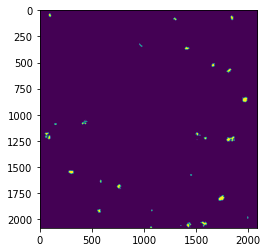

In [4]:
file_list = []
for f in subdir:
    file_list += list_items(f, ".bmp")

for f_name in file_list:
    im_bmp = np.array(Image.open(f'{f_name[:-4]}_n.png'))
#     im_mask = np.load(f_name[:-3]+'npy')
#     im_centroids = np.load(f'{f_name[:-4]}_c.npy')

    im_bmp = im_bmp / 255.0
#     im_mask = torch.FloatTensor(im_mask)[None, None, :, :]

    slider = visualizer_slider(im_bmp, crop_size=512)
    slider.make_tiles()
    im_lst = torch.FloatTensor(np.array(slider.arr)).permute(0, 3, 1, 2)

    for i in range(im_lst.shape[0]):
        data = im_lst[i:i + 1]
        generated = model(data)
        generated = generated[:, 0:1, :, :]
        
        generated[generated >= .5] = 1
        generated[generated < .5] = 0
        
        if device == 'cuda':
            generated = generated.cpu()

        slider.arr[i] = generated[0].permute(1, 2, 0).data.numpy()

    slider.recover_mask()
    
    plt.imshow(slider.recvored_mak)
    
    #Extract segmentation patches for classification
    seg_imgs, idx = extract_segmentation(slider.recvored_mak[:,:,0],crop_size=120, j=10, n =7)
    print(seg_imgs.shape, len(idx))
    
    #Classification model

    break

#     model.fake_B = torch.FloatTensor(slider.recvored_mak)[None, :, :, :].permute(0, 3, 1, 2)
#     model.im = torch.FloatTensor(im_bmp)[None, :, :, :].permute(0, 3, 1, 2)
#     visuals = model.get_current_visuals()
#     save_images(webpage, visuals, f_name.replace('/','_'), aspect_ratio=opt.aspect_ratio, width=opt.display_winsize)

#     webpage.save()

(30, 120, 120) 30
